# Домашнее задание 1

Это домашнее задание по материалам первых 4х занятий. Дедлайн сдачи - __23:59 17 марта__.

- Домашнее задание выполняется в этом же Jupyter Notebook.

- Перед отправкой файл нужно переименовать: __Фамилия_Имя_ (без пробелов в начале и конце). Пример: __Иванов_Иван__.

- Домашнее задание присылается на адрес __OptimizationHomework@yandex.ru__. Тема письма: __ИППИ_Номер_задания__ (без пробелов в начале и конце). Для этого задания тема письма: __ИППИ_1__.

- Поместите решение каждой задачи/пункта после условия.

- Не забывайте добавлять необходимые пояснения и комментарии.

- Все технические артефакты должны быть удалены в финальной версии, которая будет отправлена на проверку. Под такими артефактами понимаются любые выводы ячеек, которые никак не прокомментированы в тексте, а также любые объемные/длинные технические выводы (даже если они прокомментированы в тексте).

- Запуск решения (Kernel -> Restart & Run All) должен отработать все ячейки без ошибок.

- Максимальный балл за задание - 120. Для получения полного балла за домашнее задание необходимо набрать 100 баллов.

Желаем вам успехов!

Рассмотрим задачу минимизации эмпериечского риска с регуляризатором:
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i) + \frac{\lambda}{2} \| w\|^2_2,
\end{equation}
где $\ell: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ - функция потерь, $g : \mathbb{R}^d \times \mathbb{R}^x \to \mathbb{R}$ - модель машинного обучения, $w$ - параметры модели, $\{x_i, y_i\}_{i=1}^n$ - обучающая выборка из объектов $x_i \in \mathbb{R}^x$ и лейблов $y_i \in \mathbb{R}$.

В рамках этого задания будем использовать линейную модель $g(w, x) = w^T x$ и логистическую/сигмоидную функцию потерь: $\ell(z,y) = \ln (1 + \exp(-yz))$ (__Важно: $y$ должен принимать значения $-1$ или $1$__). Получившаяся целевая функция называется логистической регрессией.

Задачу можно переписать в следующем виде:
\begin{equation}
\min_{w \in \mathbb{R}^d} f(w) := \frac{1}{s} \sum\limits_{j=1}^s f_j(w) := \frac{1}{s} \sum\limits_{j=1}^s \left[\frac{1}{b} \sum\limits_{i=1}^b l (g(w, x_{(j-1)b + i}), y_{(j-1)b + i}) + \frac{\lambda}{2} \| w\|^2_2\right],
\end{equation}
где $b$ - размер батча, $s$ - количество батчей, и $b s = n$ - общий объем обучающей выборки.

Градиент $f_j$ может быть посчитан по формуле:
$$
\nabla f_j(w) = \frac{1}{b} \sum_{i=1}^b \frac{-y_{(j-1)b + i} x_{(j-1)b + i}}{1 + \exp(y_{(j-1)b + i} w^Tx_{(j-1)b + i})}.
$$
Константу Липшица градиента $\nabla f_j$ можно оценить по формуле $L_j = \frac{1}{4b} \sum\limits_{i=1}^b \| x_{(j-1)b + i} \|^2_2$.

## __(a). (10 баллов)__ К заданию приложен датасет _mushrooms_. С помощью следующего кода сформируйте матрицу $X$ и вектор $y$ ($X$ - матрицу из векторов $\{x_i\}$ и вектор $y$ - из $\{y_i\}$):

In [1]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from random import randrange
from numpy.linalg import norm
import time
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [2]:
dataset = "./mushrooms.txt"
#файл должен лежать в той же деректории, что и notebook

In [3]:
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
y = y.astype(int)
n, d = X.shape

## Разделите (лучше случайно) данные (а значит $X$ и $y$) на две части: обучающую и тестовую (примерно в отношении $4$ к $1$). Опишите, как это было сделано.

Для разделения датасета знаю функцию train_test_split, других не знаю. Она поидее случайно разделит данные и благодаря stratify=y по классам y разделится ,более-менее равномерно.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=65,
                                                    stratify=y
                                                    )

print(f"Количество элементов в y_train по классам: {np.bincount(y_train)}")
print(f"Количество элементов в y_test по классам: {np.bincount(y_test)}")

Количество элементов в y_train по классам: [   0 3133 3366]
Количество элементов в y_test по классам: [  0 783 842]


В начале задания написано, что y должен принимать значения 1, -1. Пусть будет.

In [5]:
ind = np.arange(0, len(y_train))
y_train[ind[y_train[ind]==2]] = -1
ind = np.arange(0, len(y_test))
y_test[ind[y_test[ind]==2]] = -1

print(y_test)
print(y_train)

[ 1  1 -1 ...  1 -1  1]
[-1 -1  1 ... -1  1  1]


## Для обучающей части $X_{train}$, $y_{train}$ оцените константу $L$. Задайте $\lambda$ так, чтобы $\lambda \approx L / 1000$.

План 1.

В описании задания есть формулка константы липшица для батча (для градиента по батчу, но при чем там градиент, я, если честно, не поняла). Решила поискать константу липшица с помощью неё.

In [6]:
def calculate_L(batch):
  L = 0

  for i in range(batch.shape[0]):
    L = L + norm(batch[i])**2

  L = L / 4 / batch.shape[0]
  return L

In [7]:
L_train_1 = calculate_L(X_train)
print(L_train_1)

5.25


План 2.

Датасет не сильно большой, так что можно его весь перебрать и по услловию непрерывноси Липшица найти минимальную константу.

In [8]:
min_abs = 10

for i in range(X_train.shape[0]):
  for j in range(X_train.shape[0]):
    if i == j or y_train[i] == y_train[j]:
      continue
    else:
      k = norm(X_train[i] - X_train[j])
      if k < min_abs:
        min_abs = k

L_train_2 = 1/min_abs *2
print(min_abs)
print(L_train_2)

2.0
1.0


Она не совпала с предыдущей L, но она и не больше, так что наверное все ок.

In [9]:
lambda1 = L_train_1 / 1000
lambda2 = L_train_2 / 1000

print("lambda1:", lambda1, "lambda2:", lambda2)

lambda1: 0.00525 lambda2: 0.001


## Реализуйте возможность равномерного разделения обучающей части набора данных на партии размером $b$ ($b$ - параметр).

In [10]:
def generate_batches(X, y, b):
  assert len(X) == len(y)
  np.random.seed(65)

  perm = np.random.permutation(len(y))

  return X[perm], y[perm]


## __б). (10 баллов)__ Реализуйте метод SGD:
$$
w^{k+1} = w^k - \gamma_k \nabla f_{j_k} (w^k),
$$
где индекс $j_k$ генерируется независимо и равномерно из $\{1, \ldots, s \}$. Для решения следующих пунктов задания Вам может понадобиться возможность измерять время работы метода (учтите это в коде).

In [11]:
class SGD:
  def __init__(self, max_epochs=100, b=10, eps=1e-5, gamma=None, gamma_type="no_type"):
    self.gamma = gamma
    self.gamma_type = gamma_type
    self.max_epochs = max_epochs
    self.b = b
    self.eps = eps
    self.w = None
    self.grad_prog = None
    self.w_prog = None
    self.time_prog = np.array([])

    if self.gamma is None and gamma_type == "no_type":
       self.gamma_type = "type1"

  def fit(self, X, y):
    n, d = X.shape
    self.w = np.random.randn(d)
    start_time = time.time()

    for i in range(self.max_epochs):
      X_batched, y_batched = generate_batches(X, y, self.b)
      for j in range(0, n // self.b):
        jk = randrange(n // self.b)

        X_batch = X_batched[self.b*jk: self.b*(jk+1)]
        y_batch = y_batched[self.b*jk: self.b*(jk+1)]

        match self.gamma_type:
          case "type1":
            L = calculate_L(X_batch)
            self.gamma = 1 / L
          case "type2":
            self.gamma = 1 / math.sqrt(j + (n // self.b)*i + 1)
          case "type3":
            self.gamma = 1 / (j + (n // self.b)*i + 1)

        grad = self.gradient(X_batch, y_batch)
        self.w = self.w - self.gamma * grad

        if self.w_prog is None:
          self.w_prog = np.array([self.w])
        else:
          self.w_prog = np.append(self.w_prog, [self.w], axis=0)

        self.time_prog = np.append(self.time_prog, [time.time() - start_time])

      if np.linalg.norm(grad) < self.eps:
        break
      if i == self.max_epochs - 1:
        print("The maximum number of epochs has been reached")
    return time.time() - start_time

  def gradient(self, X_batch, y_batch):
    grad = 0
    for i in range(0, self.b):
      grad = grad - y_batch[i] * X_batch[i] / (1 + np.exp(y_batch[i] * np.transpose(self.w) @ X_batch[i]))

    grad = grad / self.b

    if self.grad_prog is None:
      self.grad_prog = np.array([grad])
    else:
      self.grad_prog = np.append(self.grad_prog, [grad], axis=0)
    return grad

  def predict(self, X, w_k=None):

    if w_k is None:
      y_pred = X @ self.w
    else:
      y_pred = X @ w_k

    for i in range(0, len(y_pred)):
      if y_pred[i] >= 0:
        y_pred[i] = 1
      else:
        y_pred[i] = -1

    return y_pred

## __в). (10 баллов)__ Решите задачу оптимизации на обучающей выборке с помощью реализованного метода. Возьмем $b = 10$, шаг - $\gamma_k \equiv \frac{1}{L}$. Что такое $L$ в данном случае с точки зрения теории? Как вы ее нашли? Постройте график сходимости: значение критерия сходимости (например, $\frac{\| \nabla f(w^k)\|}{\| \nabla f(w^0)\|}$) от номера итерации. Подуймате над оформлением графика. Обратите внимание, что по оси $y$ лучше откладывать значения логарифмическом масштабе. Почему? Чем он лучше обычно? Сделайте вывод по всему эксперименту.

In [12]:
b = 10
gamma1 = 1 / L_train_1
gamma2 = 1 / L_train_2

In [13]:
sgd1 = SGD(max_epochs=200, b=10, eps=1e-3, gamma=gamma1)
time1 = sgd1.fit(X_train, y_train)

In [14]:
ind = np.arange(0, len(y_test))

y_train_pred1 = sgd1.predict(X_train)
y_test_pred1 = sgd1.predict(X_test)

y_train_01 = np.array(y_train)
y_train_01[ind[y_train_01[ind]==-1]] = 0

y_test_01 = np.array(y_test)
y_test_01[ind[y_test_01[ind]==-1]] = 0

y_train_pred1_01 = np.array(y_train_pred1)
y_train_pred1_01[ind[y_train_pred1_01[ind]==-1]] = 0

y_test_pred1_01 = np.array(y_test_pred1)
y_test_pred1_01[ind[y_test_pred1_01[ind]==-1]] = 0

print("time1:", time1)
print("acc1_train:", accuracy_score(y_train_pred1_01, y_train_01))
print("acc1_test:", accuracy_score(y_test_pred1_01, y_test_01))

time1: 67.38160800933838
acc1_train: 1.0
acc1_test: 1.0


In [15]:
sgd2 = SGD(max_epochs=200, b=10, eps=1e-3, gamma=gamma2)
time2 = sgd2.fit(X_train, y_train)

In [16]:
y_train_pred2 = sgd2.predict(X_train)
y_test_pred2 = sgd2.predict(X_test)

y_train_pred2_01 = np.array(y_train_pred2)
y_train_pred2_01[ind[y_train_pred2_01[ind]==-1]] = 0

y_test_pred2_01 = np.array(y_test_pred2)
y_test_pred2_01[ind[y_test_pred2_01[ind]==-1]] = 0

print("time2:", time2)
print("acc2_train:", accuracy_score(y_train_pred2_01, y_train_01))
print("acc2_test:", accuracy_score(y_test_pred2_01, y_test_01))

time2: 0.8345179557800293
acc2_train: 1.0
acc2_test: 1.0


In [17]:
sgd3 = SGD(max_epochs=200, b=10, eps=1e-3)
time3 = sgd3.fit(X_train, y_train)

In [18]:
y_train_pred3 = sgd3.predict(X_train)
y_test_pred3 = sgd3.predict(X_test)

y_train_pred3_01 = np.array(y_train_pred3)
y_train_pred3_01[ind[y_train_pred3_01[ind]==-1]] = 0

y_test_pred3_01 = np.array(y_test_pred3)
y_test_pred3_01[ind[y_test_pred3_01[ind]==-1]] = 0

print("time3:", time3)
print("acc3_train:", accuracy_score(y_train_pred3_01, y_train_01))
print("acc3_test:", accuracy_score(y_test_pred3_01, y_test_01))

time3: 49.25019884109497
acc3_train: 1.0
acc3_test: 1.0


In [19]:
def grad_plot(sgd, buf_size=1, plot=True):
  grads = sgd.grad_prog
  arr = np.zeros(grads.shape[0])
  arr_log = np.zeros(grads.shape[0])

  buff = np.array([])

  for i in range(0, grads.shape[0]):
    buff = np.append(buff, norm(grads[i])/norm(grads[0]))

    arr[i] = np.mean(buff)
    arr_log[i] = np.log(arr[i])

    if len(buff) == buf_size:
      buff = np.delete(buff, 0)

  if plot==True:
    plt.figure(1)
    plt.plot(arr)
    plt.title('Критерий сходимости в не логарифимическом масштабе, gamma =' + str(round(sgd.gamma, 2)))
    plt.xlabel('номер итерации')
    plt.ylabel('критерий сходимости')

    plt.figure(2)
    plt.plot(arr_log)
    plt.title('Критерий сходимости в логарифимическом масштабе, gamma =' + str(round(sgd.gamma, 2)))
    plt.xlabel('номер итерации')
    plt.ylabel('логарифм критерия сходимости')

    plt.show()
  return arr, arr_log

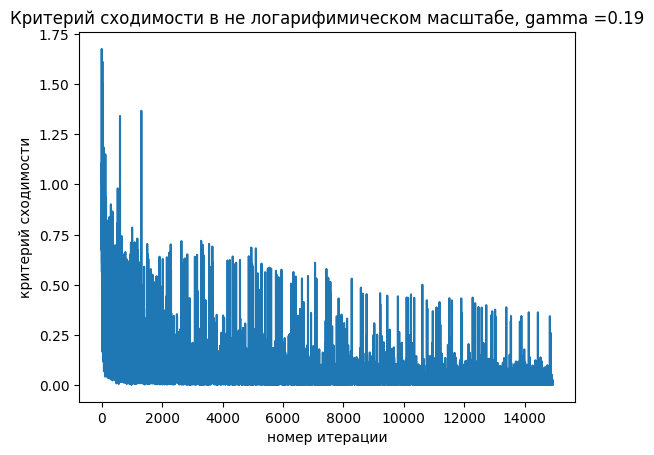

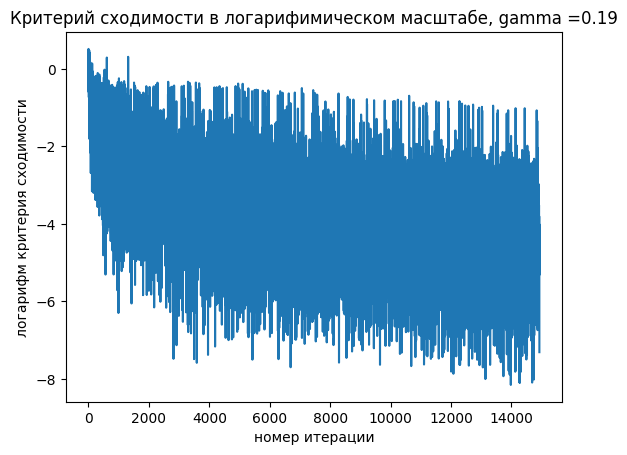

In [20]:
grad_plot(sgd1);

Судя по всему к чему-то оно сошлось. На графике с осью логарифма видна флуктуация, которая неизбежная при стохастическом градиентном спуске.

Чтобы уменьшить дисперсию на графиках, решила брать средний критерий сходимости по некоторому окну, графики стали красивее.

sgd1 - gamma посчитана с помощью L, посчитанной по формулке из начала по всему train датасету.

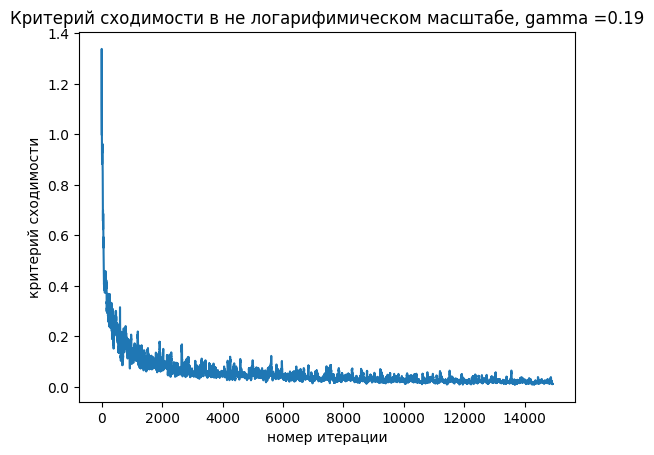

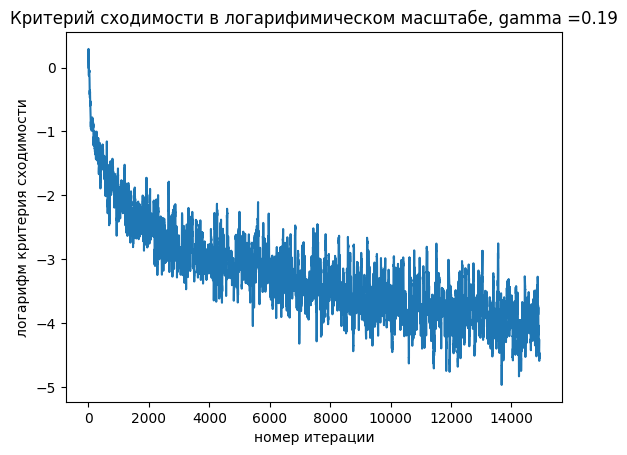

In [21]:
grad_plot(sgd1, 20);

sgd2 - gamma посчитана с помощью L найденной из услевия непрерывности Липшица для train датасета (путем перебора).

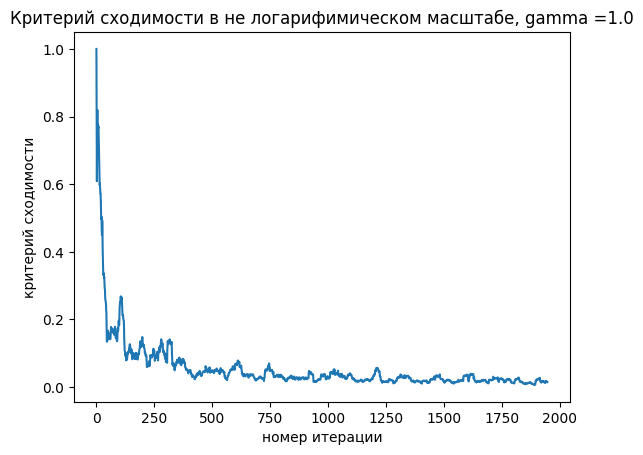

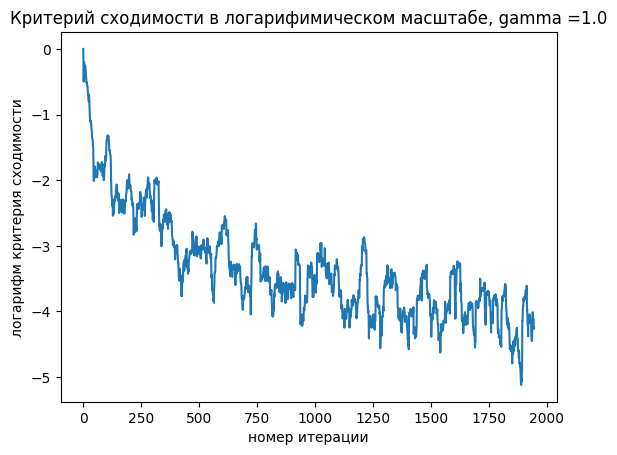

In [22]:
grad_plot(sgd2, 20);

sgd3 - gamma считается для каждого батча как 1 / L, где L посчитано для батча по формулке из начала.

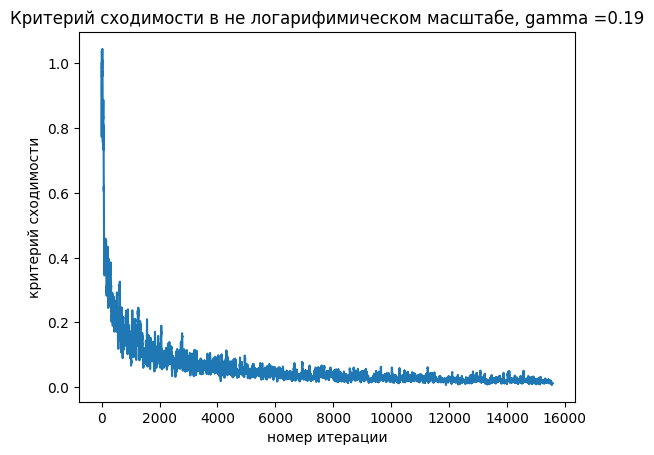

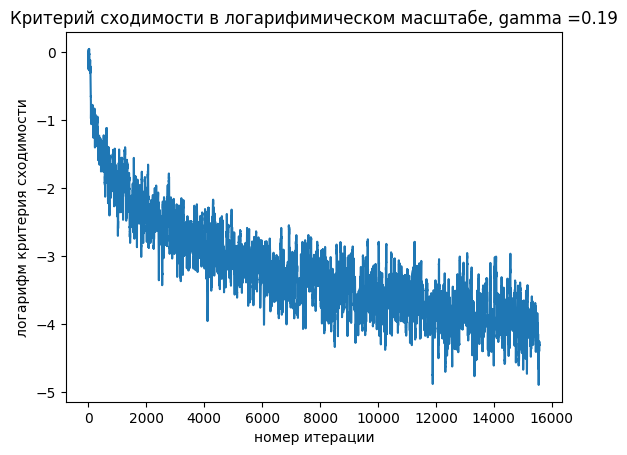

In [23]:
grad_plot(sgd3, 20);

Выводы:



1.   Оно сходится.
2.   sg1 сходится быстрее sgd3, а sgd2 сходится значительно быстрее их обоих. Значит я L нашла удачную.
3.   Графики с логарифмической осью более наглядные.
4.   Посчитала accurasy_score, получилась единица. Это, наверное, хорошо.



## __г). (10 баллов)__ Варьируйте размер батча: $b = 1, 10, 100, 1000$, а размер шага возьмите равным $\gamma_k \equiv \frac{1}{L}$. Для вашего способа вычисления $L$ нужно ли пересчитывать $L$ для каждого размера $b$? Постройте график сходимости: значение критерия сходимости от номера итерации для каждого $b$. Отражает ли этот график справедливое сравнение? Почему? Придумайте, как сравнить результаты друг с другом более честно, и постройте новый график сравнения. Сделайте вывод.

Для данного задания я выбрала gamma = gamma2 = 1 / L_train2, так как для него критерий сходимости получился наиболее красивый и алгоритм быстрее работает. Поэтому L каждый раз не пересчитываю.

In [24]:
sgd4 = SGD(max_epochs=500, b=1, eps=1e-3, gamma=gamma2)
time4 = sgd4.fit(X_train, y_train)

In [25]:
y_train_pred4 = sgd4.predict(X_train)
y_test_pred4 = sgd4.predict(X_test)

y_train_pred4_01 = np.array(y_train_pred4)
y_train_pred4_01[ind[y_train_pred4_01[ind]==-1]] = 0

y_test_pred4_01 = np.array(y_test_pred4)
y_test_pred4_01[ind[y_test_pred4_01[ind]==-1]] = 0

print("time4:", time4)
print("acc4_train:", accuracy_score(y_train_pred4_01, y_train_01))
print("acc4_test:", accuracy_score(y_test_pred4_01, y_test_01))

time4: 5.13042140007019
acc4_train: 1.0
acc4_test: 1.0


In [26]:
sgd5 = SGD(max_epochs=500, b=100, eps=1e-3, gamma=gamma2)
time5 = sgd5.fit(X_train, y_train)

In [27]:
y_train_pred5 = sgd5.predict(X_train)
y_test_pred5 = sgd5.predict(X_test)

y_train_pred5_01 = np.array(y_train_pred5)
y_train_pred5_01[ind[y_train_pred5_01[ind]==-1]] = 0

y_test_pred5_01 = np.array(y_test_pred5)
y_test_pred5_01[ind[y_test_pred5_01[ind]==-1]] = 0

print("time5:", time5)
print("acc5_train:", accuracy_score(y_train_pred5_01, y_train_01))
print("acc5_test:", accuracy_score(y_test_pred5_01, y_test_01))

time5: 16.79104447364807
acc5_train: 1.0
acc5_test: 1.0


In [28]:
sgd6 = SGD(max_epochs=1000, b=1000, eps=1e-3, gamma=gamma2)
time6 = sgd6.fit(X_train, y_train)

In [29]:
y_train_pred6 = sgd6.predict(X_train)
y_test_pred6 = sgd6.predict(X_test)

y_train_pred6_01 = np.array(y_train_pred6)
y_train_pred6_01[ind[y_train_pred6_01[ind]==-1]] = 0

y_test_pred6_01 = np.array(y_test_pred6)
y_test_pred6_01[ind[y_test_pred6_01[ind]==-1]] = 0

print("time6:", time6)
print("acc6_train:", accuracy_score(y_train_pred6_01, y_train_01))
print("acc6_test:", accuracy_score(y_test_pred6_01, y_test_01))

time6: 65.7328896522522
acc6_train: 1.0
acc6_test: 1.0


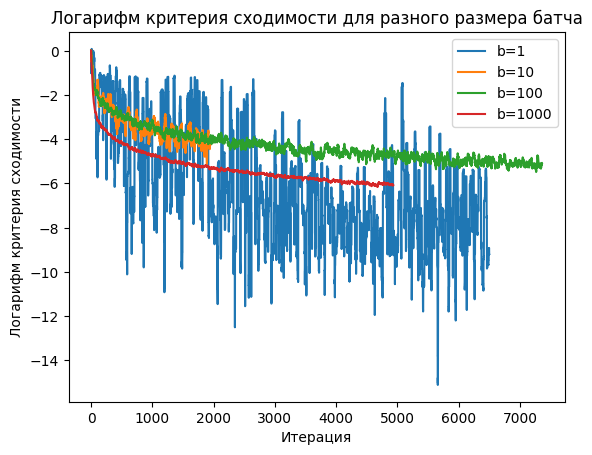

In [30]:
gr_coefs_4, gr_coefs_log_4 = grad_plot(sgd4, buf_size=20, plot=False)
gr_coefs_2, gr_coefs_log_2 = grad_plot(sgd2, buf_size=20, plot=False)
gr_coefs_5, gr_coefs_log_5 = grad_plot(sgd5, buf_size=20, plot=False)
gr_coefs_6, gr_coefs_log_6 = grad_plot(sgd6, buf_size=20, plot=False)

plt.plot(gr_coefs_log_4, label='b=1')
plt.plot(gr_coefs_log_2, label='b=10')
plt.plot(gr_coefs_log_5, label='b=100')
plt.plot(gr_coefs_log_6, label='b=1000')

plt.xlabel("Итерация")
plt.ylabel("Логарифм критерия сходимости")
plt.title("Логарифм критерия сходимости для разного размера батча")
plt.legend()
plt.show()

Справедливого сравнения из графика не видно, так как для каждой модели понятие итерации - разное. Имеется ввиду то, что обновление градиента происходит с разной "скоростью/частотой", для b=10 одна итерация сопоставима с 10-ю итерациями с b=1.

И поэтому из такого графика не определить скорость сходимости, на самом деле b=1000 сходился дольше дргих, но из графика это не видно.

Тогда, чтобы графики хотя бы примерно были сравнимы, нужно строить их для относительно одинаковых итераций. Например, будем считать общее изменение градиента сразу за несколько итераций, для b=1 за 1000, для b=10 за 100 и тд.


In [31]:
def grad_scale(sgd, scale=1, buf_size=1):
  grads = sgd.grad_prog
  arr_log = np.array([])
  buff = np.array([])

  for i in range(0, grads.shape[0] + 1):
    if i!=0 and ((i-1) // scale != i//scale):
      buff = np.append(buff, norm(np.mean(grads[i - scale:i], axis=0)) / norm(np.mean(grads[0:scale], axis=0)))
      arr_log= np.append(arr_log, np.log(np.mean(buff)))

      if len(buff) == buf_size:
        buff = np.delete(buff, 0)
  return arr_log

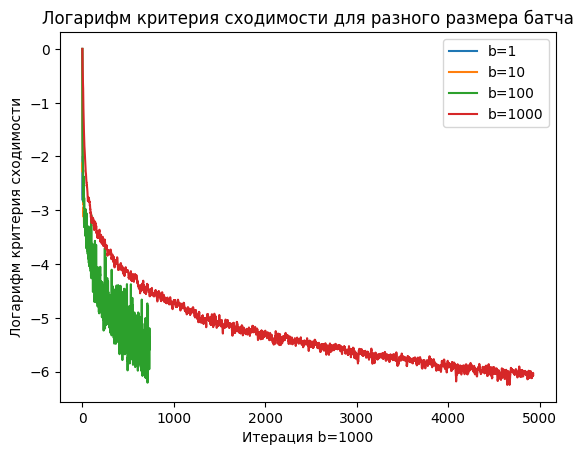

In [32]:
gr_coefs_log_4 = grad_scale(sgd4, scale=1000, buf_size=1)
gr_coefs_log_2 = grad_scale(sgd2, scale=100, buf_size=1)
gr_coefs_log_5 = grad_scale(sgd5, scale=10, buf_size=1)
gr_coefs_log_6 = grad_scale(sgd6, buf_size=10)

plt.plot(gr_coefs_log_4, label='b=1')
plt.plot(gr_coefs_log_2, label='b=10')
plt.plot(gr_coefs_log_5, label='b=100')
plt.plot(gr_coefs_log_6, label='b=1000')

plt.xlabel("Итерация b=1000")
plt.ylabel("Логарифм критерия сходимости")
plt.title("Логарифм критерия сходимости для разного размера батча")
plt.legend()
plt.show()

Здесь получилось тоже не очень наглядно, так как количество эпох разное. Поэтому попрубем пройти одинаковое количество эпох всеми и посмотреть как оно будет сходиться.

In [33]:
sgd7 = SGD(max_epochs=5, b=1, eps=1e-10, gamma=gamma2)
time7 = sgd7.fit(X_train, y_train)
print(time7)

The maximum number of epochs has been reached
316.50136160850525


In [34]:
sgd8 = SGD(max_epochs=5, b=10, eps=1e-10, gamma=gamma2)
time8 = sgd8.fit(X_train, y_train)
print(time8)

The maximum number of epochs has been reached
1.3304052352905273


In [35]:
sgd9 = SGD(max_epochs=5, b=100, eps=1e-10, gamma=gamma2)
time9 = sgd9.fit(X_train, y_train)
print(time9)

The maximum number of epochs has been reached
0.35773444175720215


In [36]:
sgd10 = SGD(max_epochs=5, b=1000, eps=1e-10, gamma=gamma2)
time10 = sgd10.fit(X_train, y_train)
print(time10)

The maximum number of epochs has been reached
0.3235793113708496


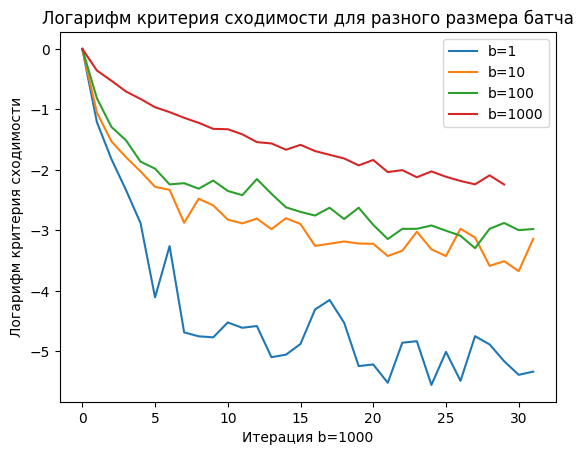

In [37]:
gr_coefs_log_7 = grad_scale(sgd7, scale=1000, buf_size=1)
gr_coefs_log_8 = grad_scale(sgd8, scale=100, buf_size=1)
gr_coefs_log_9 = grad_scale(sgd9, scale=10, buf_size=1)
gr_coefs_log_10 = grad_scale(sgd10, buf_size=1)

plt.plot(gr_coefs_log_7, label='b=1')
plt.plot(gr_coefs_log_8, label='b=10')
plt.plot(gr_coefs_log_9, label='b=100')
plt.plot(gr_coefs_log_10, label='b=1000')

plt.xlabel("Итерация b=1000")
plt.ylabel("Логарифм критерия сходимости")
plt.title("Логарифм критерия сходимости для разного размера батча")
plt.legend()
plt.show()

Для малого размера батча критерий сходимости меннее стабилен, флуктуации больше, но сходится быстреее. При большом батче оно долго сходится, зато обучение стабильнее и флуктуации меньше. Графики для батча 100 и 10 мне нравятся больше всего.

## __д). (20 баллов)__ Зафиксируем $b = 10$ и попробуем изменить стратегию выбора шага:

1) $\gamma_k \equiv \frac{1}{L}$, как мы делали раньше,

2) $\gamma_k \equiv \text{const}$, выбирая $\text{const}$ для получения "лучшей" сходимости (объясните, что вы понимать под "лучшей"),

3) $\gamma_k = \frac{1}{\sqrt{k + 1}}$,

4) $\gamma_k = \frac{1}{k + 1}$.

Постройте график сравнения: значение критерия сходимости от номера итерации. Сделайте вывод.

sgd11:

gamma_k = 1/L_k, где L_k каждый батч вычисляется по формулке.

In [38]:
sgd11 = SGD(max_epochs=20, b=10, eps=1e-5)
time11 = sgd11.fit(X_train, y_train)

The maximum number of epochs has been reached


In [39]:
y_train_pred11 = sgd11.predict(X_train)
y_test_pred11 = sgd11.predict(X_test)

y_train_pred11_01 = np.array(y_train_pred11)
y_train_pred11_01[ind[y_train_pred11_01[ind]==-1]] = 0

y_test_pred11_01 = np.array(y_test_pred11)
y_test_pred11_01[ind[y_test_pred11_01[ind]==-1]] = 0

print("time11:", time11)
print("acc11_train:", accuracy_score(y_train_pred11_01, y_train_01))
print("acc11_test:", accuracy_score(y_test_pred11_01, y_test_01))

time11: 30.246746301651
acc11_train: 1.0
acc11_test: 1.0


sgd12:

gamma = gamma2 = 1 / L_train2 = const, где L подобрано по условию непрерывности Липшица для всего train датасета.

In [40]:
sgd12 = SGD(max_epochs=20, b=10, eps=1e-5, gamma=gamma2)
time12 = sgd12.fit(X_train, y_train)

The maximum number of epochs has been reached


In [41]:
y_train_pred12 = sgd12.predict(X_train)
y_test_pred12 = sgd12.predict(X_test)

y_train_pred12_01 = np.array(y_train_pred12)
y_train_pred12_01[ind[y_train_pred12_01[ind]==-1]] = 0

y_test_pred12_01 = np.array(y_test_pred12)
y_test_pred12_01[ind[y_test_pred12_01[ind]==-1]] = 0

print("time12:", time12)
print("acc12_train:", accuracy_score(y_train_pred12_01, y_train_01))
print("acc12_test:", accuracy_score(y_test_pred12_01, y_test_01))

time12: 30.410194635391235
acc12_train: 1.0
acc12_test: 1.0


sgd13:

gamma_k = 1 / sqrt(1+k)

In [42]:
sgd13 = SGD(max_epochs=20, b=10, eps=1e-5, gamma_type="type2")
time13 = sgd13.fit(X_train, y_train)

The maximum number of epochs has been reached


In [43]:
y_train_pred13 = sgd13.predict(X_train)
y_test_pred13 = sgd13.predict(X_test)

y_train_pred13_01 = np.array(y_train_pred13)
y_train_pred13_01[ind[y_train_pred13_01[ind]==-1]] = 0

y_test_pred13_01 = np.array(y_test_pred13)
y_test_pred13_01[ind[y_test_pred13_01[ind]==-1]] = 0

print("time13:", time13)
print("acc13_train:", accuracy_score(y_train_pred13_01, y_train_01))
print("acc13_test:", accuracy_score(y_test_pred13_01, y_test_01))

time13: 30.733323335647583
acc13_train: 0.9918448992152639
acc13_test: 0.9938461538461538


sgd14:

gamma_k = 1 / (k+1)

In [44]:
sgd14 = SGD(max_epochs=20, b=10, eps=1e-3, gamma_type="type3")
time14 = sgd14.fit(X_train, y_train)

The maximum number of epochs has been reached


In [45]:
y_train_pred14 = sgd14.predict(X_train)
y_test_pred14 = sgd14.predict(X_test)

y_train_pred14_01 = np.array(y_train_pred14)
y_train_pred14_01[ind[y_train_pred14_01[ind]==-1]] = 0

y_test_pred14_01 = np.array(y_test_pred14)
y_test_pred14_01[ind[y_test_pred14_01[ind]==-1]] = 0

print("time14:", time13)
print("acc14_train:", accuracy_score(y_train_pred14_01, y_train_01))
print("acc14_test:", accuracy_score(y_test_pred14_01, y_test_01))

time14: 30.733323335647583
acc14_train: 0.8704416064009848
acc14_test: 0.8806153846153846


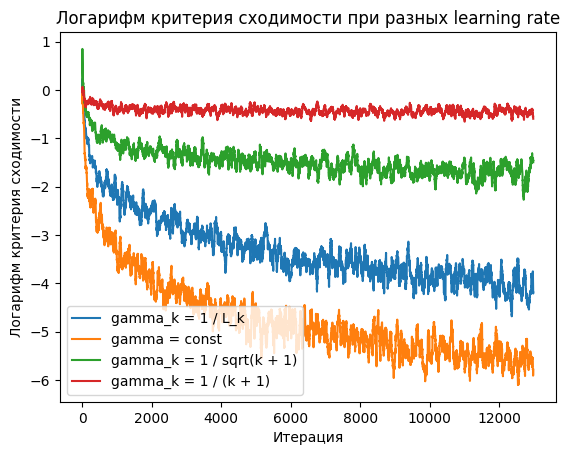

In [46]:
gr_coefs_log_11 = grad_scale(sgd11, buf_size=50)
gr_coefs_log_12 = grad_scale(sgd12, buf_size=50)
gr_coefs_log_13 = grad_scale(sgd13, buf_size=50)
gr_coefs_log_14 = grad_scale(sgd14, buf_size=50)

plt.plot(gr_coefs_log_11, label='gamma_k = 1 / L_k')
plt.plot(gr_coefs_log_12, label='gamma = const')
plt.plot(gr_coefs_log_13, label='gamma_k = 1 / sqrt(k + 1)')
plt.plot(gr_coefs_log_14, label='gamma_k = 1 / (k + 1)')

plt.xlabel("Итерация")
plt.ylabel("Логарифм критерия сходимости")
plt.title("Логарифм критерия сходимости при разных learning rate")
plt.legend()
plt.show()

Поставила максимальное количество эпох и eps градиента такими, чтобы графики были по длине одинаковые.

Выводы:
1. В случаях gamma_k = 1 / sqrt(k + 1) и gamma_k = 1 / (k + 1), модель сходится плохо, градиент меняется медленно, и по итогу оно не досчтигает такой маленькой нормы градиента как другие.
2. При gamma = const модель сходится лучше всего, достигает eps=1e-4.
3. При gamma_k = L_k оно сходится тоже хорошо, но похуже, достигает eps=1e-3.

eps здесь -- это норма градиента, при которой обучение заканчивается.

## __(e). (20 баллов)__ Как использовать итоговую модель для предсказания? Ответив на вопрос, сделайте предсказания на тестовой выборке. Сравните с реальными метками. Количество правильно угаданных меток есть точность/accuracy вашей модели. Запустите еще раз эксперимент из пункта д), постройте как меняется точность модели от времени работы метода. Сделайте вывод.

При решении задач ранее также делались предсказания и считалась точность. Предсказание считается как y_pred = X @ w, где w -- итоговые веса, после чего определяется 1 это или -1, по близости к ним (что ближе, то и будет). Для подсчета метрики accurasy_score класс -1 представляем в 0.

В экспериментах, где модель хорошо сходилась accuracy score получалась 1.

In [47]:
def w_acc(sgd, X_test, y_test_01):
  ws = sgd.w_prog
  time_arr = sgd.time_prog
  arr = np.array([])

  for i in range(0, ws.shape[0]):
    y_test_pred_01 = sgd.predict(X_test, ws[i])
    y_test_pred_01[ind[y_test_pred_01[ind]==-1]] = 0

    res = accuracy_score(y_test_pred_01, y_test_01)

    arr = np.append(arr, [res])
  return arr, time_arr

In [48]:
acc_11, time_11 = w_acc(sgd11, X_test, y_test_01)
acc_12, time_12 = w_acc(sgd12, X_test, y_test_01)
acc_13, time_13 = w_acc(sgd13, X_test, y_test_01)
acc_14, time_14 = w_acc(sgd14, X_test, y_test_01)

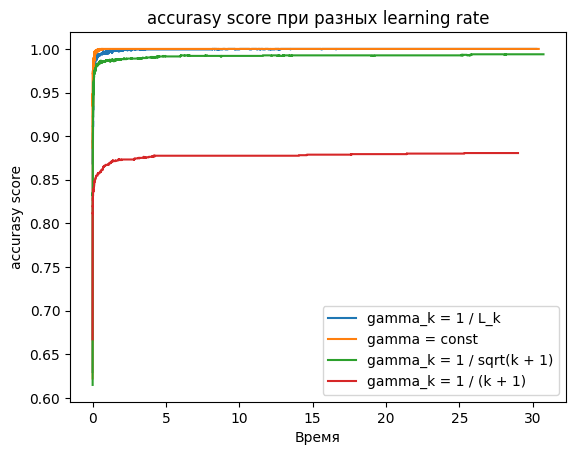

In [49]:
plt.plot(time_11, acc_11, label='gamma_k = 1 / L_k')
plt.plot(time_12, acc_12, label='gamma = const')
plt.plot(time_13, acc_13, label='gamma_k = 1 / sqrt(k + 1)')
plt.plot(time_14, acc_14, label='gamma_k = 1 / (k + 1)')

plt.xlabel("Время")
plt.ylabel("accurasy score")
plt.title("accurasy score при разных learning rate")
plt.legend()
plt.show()

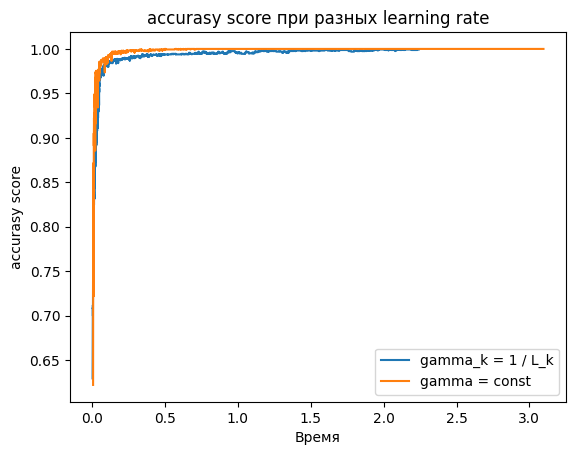

In [50]:
plt.plot(time_11[0:4000], acc_11[0:4000], label='gamma_k = 1 / L_k')
plt.plot(time_12[0:4600], acc_12[0:4600], label='gamma = const')

plt.xlabel("Время")
plt.ylabel("accurasy score")
plt.title("accurasy score при разных learning rate")
plt.legend()
plt.show()

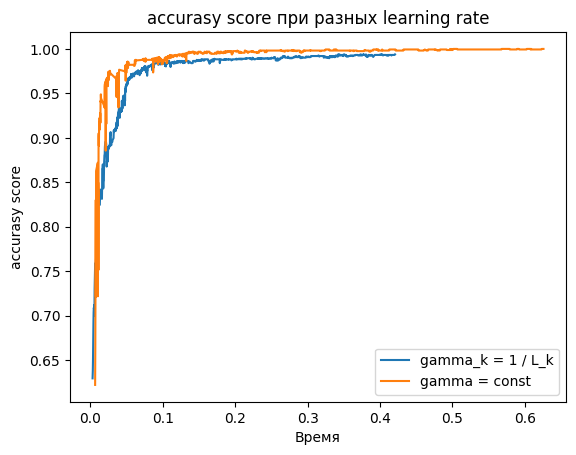

In [51]:
plt.plot(time_11[0:1350], acc_11[0:1350], label='gamma_k = 1 / L_k')
plt.plot(time_12[0:1600], acc_12[0:1600], label='gamma = const')

plt.xlabel("Время")
plt.ylabel("accurasy score")
plt.title("accurasy score при разных learning rate")
plt.legend()
plt.show()

Вывод:



1.   Точность моделей с learning rate = 1 / sqrt(k+1); = 1 / (k+1); Со временем выходит на константу и не меняется, не достигая возможного максимума.
2.   learning rate = 1 / sqrt(k+1); имеет точность большую чем learning rate = 1 / (k+1)
3.   Лучшую всего точность выдают модели с learning rate = const = 1/L_train2 и learning rate = 1/L_k. Они достигают единицы.
4.   Модель с learning rate = const = 1/L_train2 быстрее достигает accuracy_score = 1, однако в процессе точность скачет.


## __ж). (2 $\times$ 20 баллов)__ Реализуйте методы SAGA (раздел А.5 из [статьи](https://arxiv.org/pdf/1905.11261.pdf)), SVRG (раздел А.9 из [статьи](https://arxiv.org/pdf/1905.11261.pdf)) для нашей задачи. Решите задачу оптимизации на обучающей выборке с помощью новых реализованных методов. Возьмите $b = 10$, а гиперпараметры методов - согласно теории (см. соответствующие теоретические результаты из статьи). Выпишите эти параметры для удобства. Справедливо ли сравнивать эти методы между собой по числу итераций? Придумайте, как сравнить результаты более честно. Нарисуйте графики сравнения SGD (с шагом $\gamma_k \equiv \frac{1}{L}$), SAGA, SVRG (с шагами из теории): 1) значение критерия сходимости от выбранного вами критерия сравнения, 2) точность предсказаний от выбранного вами критерия. Сделайте вывод.

Не понимаю про какие именно гиперпараметры речь, если про то, что в таблице, то не понятно что с этим делать и куда девать в алгоритме.

In [52]:
class SVRG:
  def __init__(self, max_epochs=100, b=10, eps=1e-5, gamma=None, gamma_type="no_type"):
    self.gamma = gamma
    self.gamma_type = gamma_type
    self.max_epochs = max_epochs
    self.b = b
    self.eps = eps
    self.w = None
    self.grad_prog = None
    self.w_prog = None
    self.time_prog = np.array([])

    if self.gamma is None and gamma_type == "no_type":
       self.gamma_type = "type1"

  def fit(self, X, y):
    n, d = X.shape

    self.w = np.random.randn(d)
    phi = self.w
    start_time = time.time()

    for i in range(self.max_epochs):
      X_batched, y_batched = generate_batches(X, y, self.b)

      grad_phi = self.gradient(X_batched[0:n // self.b], y_batched[0:n // self.b], phi)

      for j in range(0, n // self.b):
        jk = randrange(n // self.b)

        X_batch = X_batched[self.b*jk: self.b*(jk+1)]
        y_batch = y_batched[self.b*jk: self.b*(jk+1)]

        match self.gamma_type:
          case "type1":
            L = calculate_L(X_batch)
            self.gamma = 1 / L
          case "type2":
            self.gamma = 1 / math.sqrt(j + (n // self.b)*i + 1)
          case "type3":
            self.gamma = 1 / (j + (n // self.b)*i + 1)

        # Я не понимаю как тут нормально и правильно считать градиент, судя по формуле должно быть что-то такое.
        grad = self.gradient(X_batch, y_batch) - self.gradient(X_batch, y_batch, phi) + grad_phi
        self.w = self.w - self.gamma * grad

        if self.w_prog is None:
          self.w_prog = np.array([self.w])
        else:
          self.w_prog = np.append(self.w_prog, [self.w], axis=0)

        self.time_prog = np.append(self.time_prog, [time.time() - start_time])

      if np.linalg.norm(grad) < self.eps:
        break
      if i == self.max_epochs - 1:
        print("The maximum number of epochs has been reached")

      phi = np.mean(self.w_prog[i* (n // self.b):], axis=0)

    return time.time() - start_time

  def gradient(self, X_batch, y_batch, phi=None):
    grad = 0

    if phi is not None:
      w = phi
    else:
      w = self.w

    for i in range(0, self.b):
      grad = grad - y_batch[i] * X_batch[i] / (1 + np.exp(np.float128(y_batch[i] * np.transpose(w) @ X_batch[i])))

    grad = grad / self.b

    if self.grad_prog is None:
      self.grad_prog = np.array([grad])
    else:
      self.grad_prog = np.append(self.grad_prog, [grad], axis=0)
    return grad

  def predict(self, X, w_k=None):

    if w_k is None:
      y_pred = X @ self.w
    else:
      y_pred = X @ w_k

    for i in range(0, len(y_pred)):
      if y_pred[i] >= 0:
        y_pred[i] = 1
      else:
        y_pred[i] = -1

    return y_pred

In [53]:
svrg1 = SVRG(max_epochs=200, b=10, eps=1e-4, gamma_type="type2")
svrg1_time1 = svrg1.fit(X_train, y_train)

In [54]:
y_train_pred1 = svrg1.predict(X_train)
y_test_pred1 = svrg1.predict(X_test)

y_train_pred1_01 = np.array(y_train_pred1)
y_train_pred1_01[ind[y_train_pred1_01[ind]==-1]] = 0

y_test_pred1_01 = np.array(y_test_pred1)
y_test_pred1_01[ind[y_test_pred1_01[ind]==-1]] = 0

print("svrg1_time1:", svrg1_time1)
print("acc1_train:", accuracy_score(y_train_pred1_01, y_train_01))
print("acc1_test:", accuracy_score(y_test_pred1_01, y_test_01))

svrg1_time1: 9.432147741317749
acc1_train: 0.775196184028312
acc1_test: 0.7803076923076923


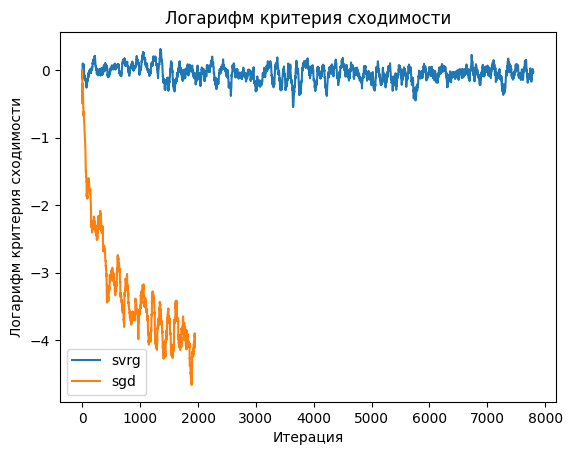

In [55]:
svrg_coefs_log_1 = grad_scale(svrg1, buf_size=50)
sgd_coefs_log_1 = grad_scale(sgd2, buf_size=50)

plt.plot(svrg_coefs_log_1, label="svrg")
plt.plot(sgd_coefs_log_1, label="sgd")

plt.xlabel("Итерация")
plt.ylabel("Логарифм критерия сходимости")
plt.title("Логарифм критерия сходимости")
plt.legend()
plt.show()

С одной стороны, теперь я могу поставить норму градиента при которой оно перестанет работать очень маленькой, что и должно быть, ведь теперь градиент не флуктуирует. С другой стороны, график сходимости странный и какой-то несходящийся. Возможно, дело в том, что так их сравнивать нельзя, потому что градиенты считаются по разному и нормы соотношений градиентов имеют другой смысл.

In [56]:
acc_sgd2, time_sgd2 = w_acc(sgd2, X_test, y_test_01)
acc_svrg1, time_svrg1 = w_acc(svrg1, X_test, y_test_01)

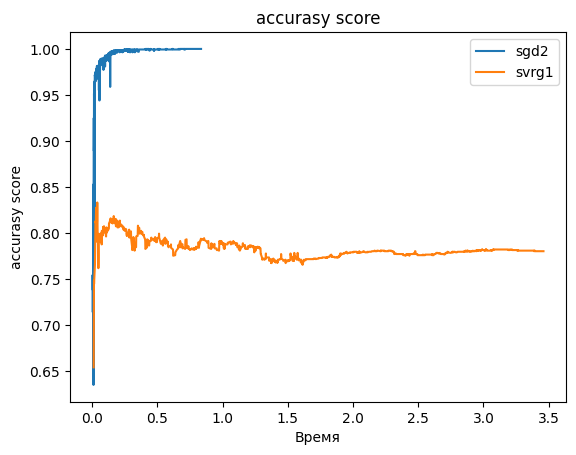

In [57]:
plt.plot(time_sgd2, acc_sgd2, label='sgd2')
plt.plot(time_svrg1[0:1500], acc_svrg1[0:1500], label='svrg1')

plt.xlabel("Время")
plt.ylabel("accurasy score")
plt.title("accurasy score")
plt.legend()
plt.show()

accurasy score от времени уже сравнивать более справедливо и у моего svrg он не очень хороший. Либо я изначалньо его написала неправильно, либо я не понимаю что не то.